# 4 Creating feature with clustering

In this exercise, we will see how to use unsupervised learning technique for creating features (e.g. k-means Clustering).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [2]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [3]:
data_path="../../data/ames.csv.zip"

In [4]:
df=pd.read_csv(data_path)

In [5]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


## 4.1 Scaling Features

The k-means algorithm is **sensitive to scale**. This means we need to be thoughtful about how and whether we rescale our features since we might get very different results depending on our choices. As a rule of thumb, if the features are already directly comparable (like a test result at different times), then you would not want to rescale. On the other hand, features that aren't on comparable scales (like height and weight) will usually benefit from rescaling. Sometimes, the choice won't be clear though. In that case, you should try to use common sense, remembering that **features with larger values will be weighted more heavily**.


### 4.1.1 Q1 Do we need to scale the following feature?

We have three possible answers:
- they definitely should be rescaled,
- they definitely should not be rescaled
- either choice might be reasonable

1. `Latitude` and `Longitude` of cities in California ?

```text
No, since rescaling would distort the natural distances described by Latitude and Longitude.
```

2. `Number of Doors` and `Horsepower` of a 1989 model car

```text
Yes, since these don't have comparable units. Without rescaling, the number of doors in a car (usually 2 or 4) would have negligible weight compared to its horsepower (usually in the hundreds).
```

3. `Lot Area` and `Green Living Area` of houses in Ames, Iowa




In [9]:
# first let's get the exact column name of these feature
import re
for col_name in df.columns:
    if re.search("area",col_name,re.IGNORECASE):
        print(col_name)

# the column name is "LotArea" and "GrLivArea"

LotArea
MasVnrArea
GrLivArea
GarageArea
PoolArea


In [8]:
# now, lets check their values
df[["LotArea","GrLivArea"]].head()

,LotArea,GrLivArea
0,31770.0,1656.0
1,11622.0,896.0
2,14267.0,1329.0
3,11160.0,2110.0
4,13830.0,1629.0


```text
Either choice could be reasonable, they both have the same unity(square foot). but because the living area of a home tends to be more valuable per square foot, it would make sense to rescale these features so that lot area isn't weighted in the clustering out of proportion to its effect on SalePrice, if that is what you were trying to predict.
```

What you should take away from this is that **the decision of whether and how to rescale features is rarely automatic** -- it will usually depend on some domain knowledge about your data and what you're trying to predict. Comparing different rescaling schemes through cross-validation can also be helpful. (You might like to check out the preprocessing module in scikit-learn for some of the rescaling methods it offers.)

## 4.2 Create a feature of cluster labels

Creating a k-means clustering with the following parameters:

features: LotArea, TotalBsmtSF, FirstFlrSF, SecondFlrSF,GrLivArea
number of clusters: 10
iterations: 10

In [10]:
X = df.copy()
y = X.pop("SalePrice")

# feature to be used for the clustering
features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF","GrLivArea"]

In [11]:
# Standardize, here we use this (row_val-mean(column))/std(column) to scale the features
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


In [12]:
# first we create a kmeans model with required parameters
# if we don't give any parameter, below default parameter will be used
# - n_clusters= 8,
# - init= "k-means++",
# - n_init = 10,
# - max_iter = 300,
# - tol = 1e-4,
# - verbose = 0,
# - random_state = None,
# - copy_x = True,
# - algorithm = "lloyd"

# As the question required, we set n_clusters=10: which specifies the number of clusters is 10
# the default init is 10, so we specify nothing, we used the default value

kmeans = KMeans(n_clusters=10, random_state=0)

In [13]:
# Now we can train the model with scaled feature

X["Cluster"] = kmeans.fit_predict(X_scaled)

In [16]:
X[features+["Cluster"]].head()

,LotArea,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea,Cluster
0,31770.0,1080.0,1656.0,0.0,1656.0,9
1,11622.0,882.0,896.0,0.0,896.0,5
2,14267.0,1329.0,1329.0,0.0,1329.0,0
3,11160.0,2110.0,2110.0,0.0,2110.0,6
4,13830.0,928.0,928.0,701.0,1629.0,3


We can also visualize the result of clustering

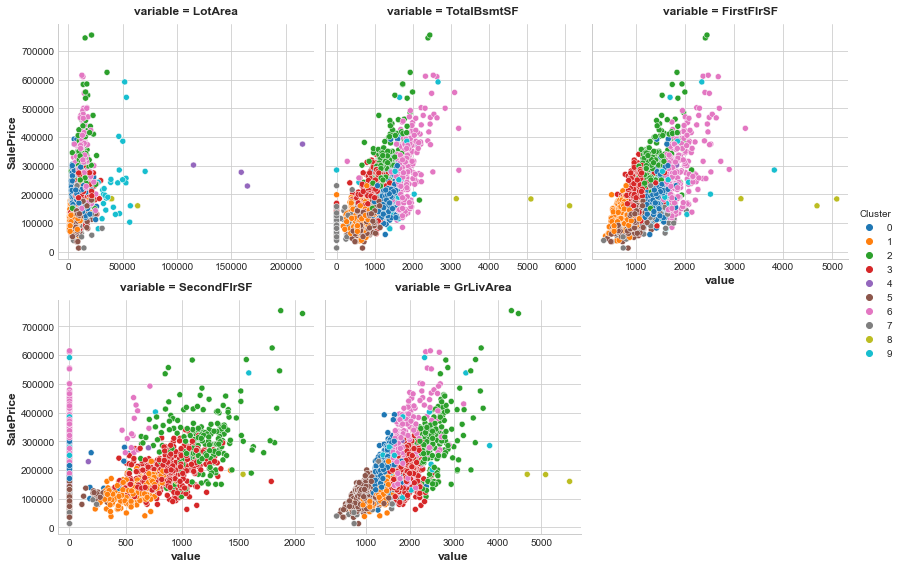

In [17]:
X_viz = X.copy()
X_viz["Cluster"] = X_viz.Cluster.astype("category")
X_viz["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=X_viz.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);